## Final Project: Fantasy Sports Assistant 

#### 1.1 Handle imports up-front 


In [1]:
import time
import urllib.request
from itertools import product
from random import randrange
import pandas as pd
from bs4 import BeautifulSoup

#### 2.0 Load the Dataset


In [2]:
def download_url(url: str) -> bytes:
    '''Takes string url, downloads URL and returns HTML bytes object'''
    headers={
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
        "Accept-Language": "en-US,en;q=0.9",
        "Connection": "keep-alive",
        "Host": "httpbin.io",
        "Sec-Ch-Ua": '"Google Chrome";v="131", "Chromium";v="131", "Not_A Brand";v="24"',
        "Sec-Ch-Ua-Mobile": "?0",
        "Sec-Ch-Ua-Platform": '"Linux"',
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "cross-site",
        "Sec-Fetch-User": "?1",
        "Upgrade-Insecure-Requests": "1",
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36"
    }
    # Create the request
    request_params = urllib.request.Request(
        url=url,
        headers=headers
    )
    # Get the html
    with urllib.request.urlopen(request_params) as response:
        html=response.read()
    return html

In [3]:
def parse_html_table(html: bytes, year: int, week: int, position: str, profile: str) -> pd.DataFrame:
    '''Takes a html bytes object from URL, parses data table, adds
    year, week, position and scoring profile and returns as pandas dataframe'''
    # Extract the table rows
    soup=BeautifulSoup(html, 'html.parser')
    table=soup.find('table',{'class':'datasmall table'})
    table_rows=table.find_all('tr')
    # Get the column names from the first row
    columns=table_rows[0].find_all('th')
    column_names=[column.getText() for column in columns]
    column_names.extend(['Position', 'Year', 'Week', 'Scoring profile'])
    # Get the values for each row
    data=[]
    for row in table_rows[1:]:
        columns=row.find_all('td')
        values=[column.getText() for column in columns]
        values.extend([position, year, week, profile])
        data.append(values)
    # Convert to pandas dataframe and return
    return pd.DataFrame(columns=column_names, data=data)

In [4]:
# Main script to download data
download_data = True  # Or False, depending on what you want to do
if download_data is True:
    positions = ['qb', 'rb', 'wr', 'te']
    profile = 'p'
    years = list(range(2020, 2024))
    weeks = list(range(1, 19))
    results = []
    for position, year, week in product(positions, years, weeks):
        print(f'Downloading {position.upper()}, {year}, week {week}')
        url = f'https://www.footballguys.com/playerhistoricalstats?pos={position}&yr={year}&startwk={week}&stopwk={week}&profile={profile}'
        # Get the HTML
        html = download_url(url)
        # Parse the HTML
        result = parse_html_table(html, position, year, week, profile)
        # Collect the result
        results.append(result)
        # Wait before downloading the next page
        time.sleep(randrange(1, 5))
    # Combine the week-by-week dataframes
    data_df = pd.concat(results)
elif download_data is False:
    data_df = pd.read_parquet('../data/raw_qb_data.parquet')
    print('Loaded data from file')
# View the resulting DataFrame
print(data_df.head())

  Rank                Name   Age   Exp  G Cmp Att   Cm%  PYd  Y/Att  ...  \
0    1      Josh Allen BUF  24.0   3.0  1  33  46  71.7  312   6.78  ...   
1    2  Russell Wilson SEA  32.0   9.0  1  31  35  88.6  322   9.20  ...   
2    3    Aaron Rodgers GB  37.0  16.0  1  32  44  72.7  364   8.27  ...   
3    4   Lamar Jackson BAL  23.0   3.0  1  20  25  80.0  275  11.00  ...   
4    5    Kyler Murray ARI  23.0   2.0  1  26  40  65.0  230   5.75  ...   

  FantPt Position Year  Week Scoring profile Y/Rsh  Rec  RecYd RecTD  Y/Rec  
0   32.2        1   qb  2020               p   NaN  NaN    NaN   NaN    NaN  
1   31.8        1   qb  2020               p   NaN  NaN    NaN   NaN    NaN  
2   30.8        1   qb  2020               p   NaN  NaN    NaN   NaN    NaN  
3   27.5        1   qb  2020               p   NaN  NaN    NaN   NaN    NaN  
4   26.3        1   qb  2020               p   NaN  NaN    NaN   NaN    NaN  

[5 rows x 26 columns]


In [5]:
test_df = data_df.copy()
test_df[['Player', 'Team']] = test_df['Name'].str.extract(r'^(.*?\b(?:I{1,3}|IV)?)(?:\s+)([A-Z]{2,3})$')
test_df.drop(columns=['Name'], inplace=True)
test_df.rename(columns={'Position': 'Week', 'Year': 'Position', 'Week': 'Year'}, inplace=True)
test_df.head()

,Rank,Age,Exp,G,Cmp,Att,Cm%,PYd,Y/Att,PTD,...,Position,Year,Scoring profile,Y/Rsh,Rec,RecYd,RecTD,Y/Rec,Player,Team
0,1,24.0,3.0,1,33,46,71.7,312,6.78,2,...,qb,2020,p,NaN,NaN,NaN,NaN,NaN,Josh Allen,BUF
1,2,32.0,9.0,1,31,35,88.6,322,9.20,4,...,qb,2020,p,NaN,NaN,NaN,NaN,NaN,Russell Wilson,SEA
2,3,37.0,16.0,1,32,44,72.7,364,8.27,4,...,qb,2020,p,NaN,NaN,NaN,NaN,NaN,Aaron Rodgers,GB
3,4,23.0,3.0,1,20,25,80.0,275,11.00,3,...,qb,2020,p,NaN,NaN,NaN,NaN,NaN,Lamar Jackson,BAL
4,5,23.0,2.0,1,26,40,65.0,230,5.75,1,...,qb,2020,p,NaN,NaN,NaN,NaN,NaN,Kyler Murray,ARI


### 3.0 EDA

### 3.1 Missing/extreme values 

Missing values per column:
Age                        0
Exp                        0
G                          0
Cmp                        0
Att                        0
                          ..
Name_Zander Horvath LAC    0
Name_Zay Flowers BAL       0
Name_Zay Jones JAX         0
Name_Zay Jones LV          0
Name_Zonovan Knight DET    0
Length: 1376, dtype: int64


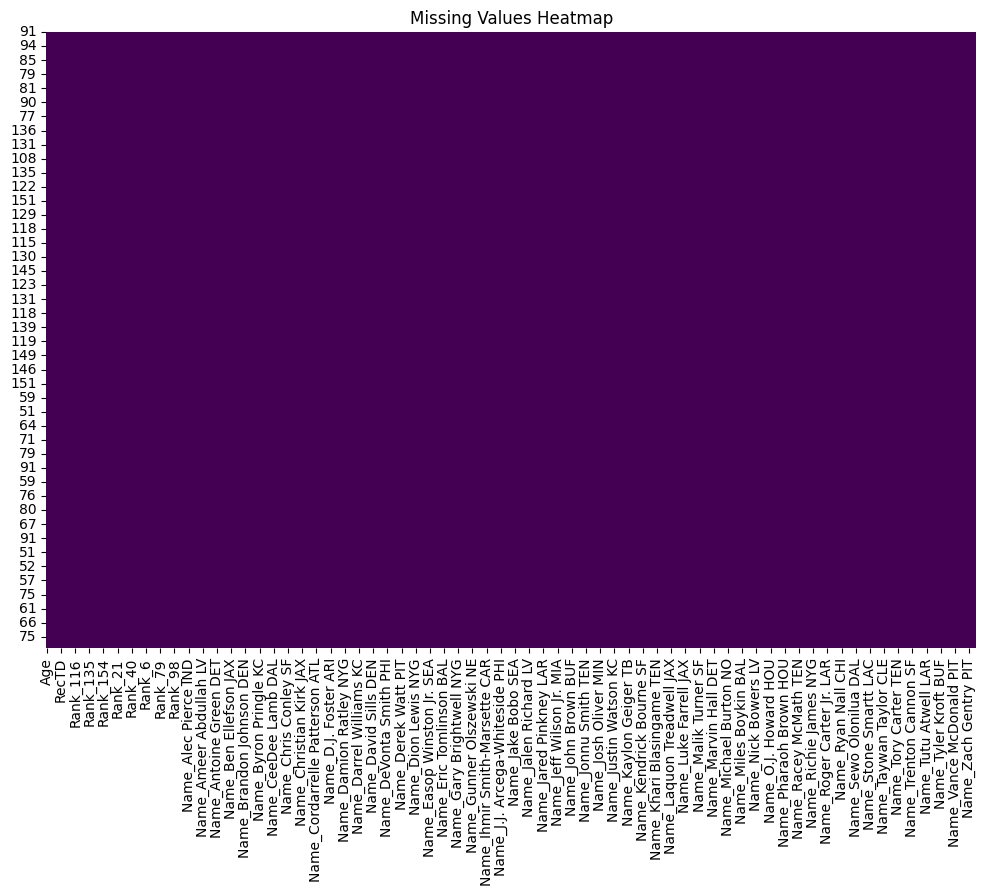

In [58]:
# Check missing values across all columns
missing_values = data_df.isnull().sum()
print("Missing values per column:")
print(missing_values)

# You can also visualize missing values with a heatmap if you prefer
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap to visualize missing values
plt.figure(figsize=(12, 8))
sns.heatmap(data_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [59]:
data_df = data_df.apply(lambda col: col.fillna(col.mode()[0]) if col.dtypes == 'O' else col)

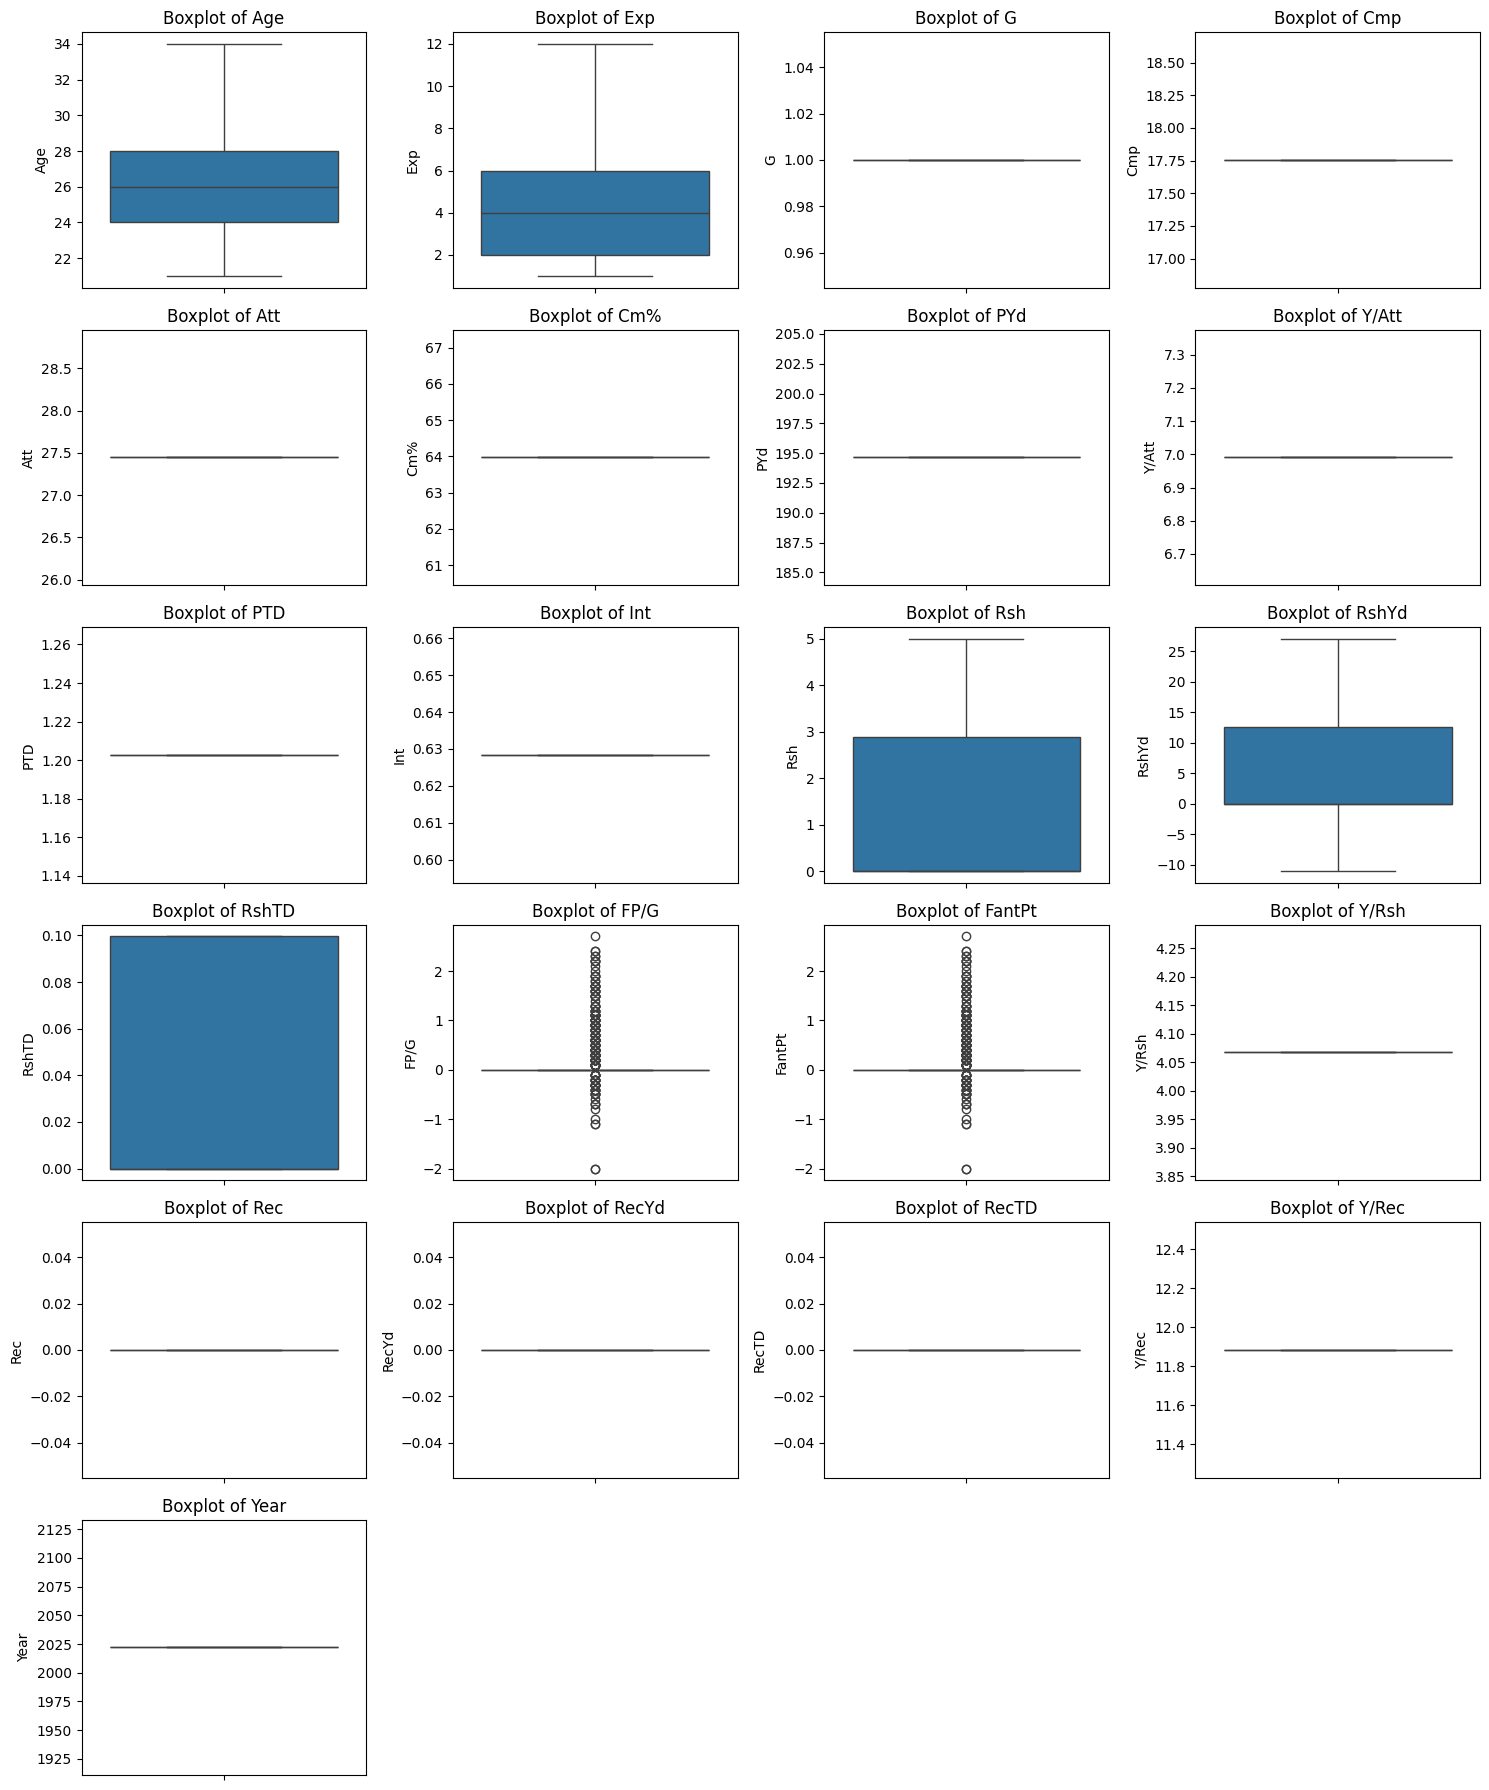

In [61]:
# Visualizing outliers for some important numeric columns
import seaborn as sns
import matplotlib.pyplot as plt

# List of numeric columns you want to check
numeric_columns = [
    'Age', 'Exp', 'G', 'Cmp', 'Att', 'Cm%', 'PYd', 'Y/Att', 'PTD', 'Int', 
    'Rsh', 'RshYd', 'RshTD', 'FP/G', 'FantPt', 'Y/Rsh', 'Rec', 'RecYd', 
    'RecTD', 'Y/Rec', 'Year'
]

# Set up the number of rows and columns dynamically to handle more than 20 subplots
num_columns = 4  # You can adjust this number as per your need
num_rows = (len(numeric_columns) + num_columns - 1) // num_columns  # Ensures enough rows for all plots

plt.figure(figsize=(15, num_rows * 3))  # Adjusting figure size based on number of rows
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(num_rows, num_columns, i)
    sns.boxplot(data_df[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

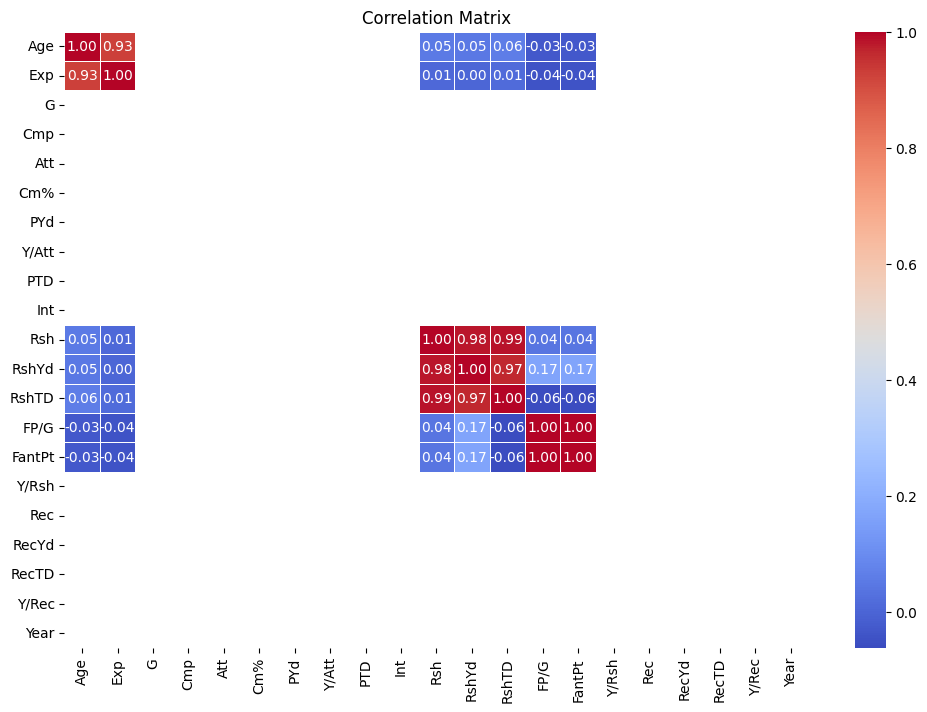

In [62]:
# Compute the correlation matrix
correlation_matrix = data_df[numeric_columns].corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#### 4.0 Feature Engineering 

In [63]:
from sklearn.preprocessing import StandardScaler

# Apply Standard Scaler to numeric columns
scaler = StandardScaler()
data_df[numeric_columns] = scaler.fit_transform(data_df[numeric_columns])

# Check if scaling worked
print(data_df.head())

         Age       Exp    G           Cmp           Att           Cm%  PYd  \
91  0.422888  0.760270  0.0  7.105427e-15 -1.065814e-14 -1.421085e-14  0.0   
92  0.812965  0.760270  0.0  7.105427e-15 -1.065814e-14 -1.421085e-14  0.0   
93 -0.747342 -1.202391  0.0  7.105427e-15 -1.065814e-14 -1.421085e-14  0.0   
94 -0.747342 -0.809859  0.0  7.105427e-15 -1.065814e-14 -1.421085e-14  0.0   
95  0.422888  0.760270  0.0  7.105427e-15 -1.065814e-14 -1.421085e-14  0.0   

           Y/Att           PTD           Int  ...  Name_Zach Pascal ARI  \
91  8.881784e-16  2.220446e-16  1.110223e-16  ...                 False   
92  8.881784e-16  2.220446e-16  1.110223e-16  ...                 False   
93  8.881784e-16  2.220446e-16  1.110223e-16  ...                 False   
94  8.881784e-16  2.220446e-16  1.110223e-16  ...                 False   
95  8.881784e-16  2.220446e-16  1.110223e-16  ...                 False   

    Name_Zach Pascal IND  Name_Zach Pascal PHI  Name_Zack Kuntz NYJ  \
91       

#### 5.0 Model selection 

In [65]:
print(data_df.columns)

Index(['Age', 'Exp', 'G', 'Cmp', 'Att', 'Cm%', 'PYd', 'Y/Att', 'PTD', 'Int',
       ...
       'Name_Zach Pascal ARI', 'Name_Zach Pascal IND', 'Name_Zach Pascal PHI',
       'Name_Zack Kuntz NYJ', 'Name_Zamir White LV', 'Name_Zander Horvath LAC',
       'Name_Zay Flowers BAL', 'Name_Zay Jones JAX', 'Name_Zay Jones LV',
       'Name_Zonovan Knight DET'],
      dtype='object', length=1376)


In [73]:
df_model_clean = df_model.drop(columns=[col for col in df_model.columns if 'Name_' in col or col == 'Player'])

# Now, check the remaining columns
print(df_model_clean.columns)

Index(['Age', 'Exp', 'G', 'Cmp', 'Att', 'Cm%', 'PYd', 'Y/Att', 'PTD', 'Int',
       ...
       'Rank_90', 'Rank_91', 'Rank_92', 'Rank_93', 'Rank_94', 'Rank_95',
       'Rank_96', 'Rank_97', 'Rank_98', 'Rank_99'],
      dtype='object', length=191)


In [75]:
# Define the feature set (X) and target variable (y)
X = df_model_clean.drop(columns=['FantPt', 'Position'])  # Drop 'FantPt' as it's the target
y = df_model_clean['FantPt']  # 'FantPt' is our target variable

#### 5.1 Train-test-split

In [76]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the splits to verify
print(f"Training data shape (X_train): {X_train.shape}")
print(f"Test data shape (X_test): {X_test.shape}")

Training data shape (X_train): (5116, 189)
Test data shape (X_test): (1280, 189)


In [77]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize Linear Regression
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train, y_train)

# Make predictions
y_pred_linear = linear_model.predict(X_test)

# Evaluate the model
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"Linear Regression - Mean Squared Error: {mse_linear}")
print(f"Linear Regression - R-squared: {r2_linear}")

Linear Regression - Mean Squared Error: 1.9921280686210246e-30
Linear Regression - R-squared: 1.0


#### 5.2 Random Forest Model with Grid Search

In [78]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define the model (Random Forest Regressor)
rf_model = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples required to be at a leaf node
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the model to the data (this can take a while)
grid_search.fit(X_train, y_train)

# Get the best parameters
print(f"Best parameters found: {grid_search.best_params_}")

# Best model after grid search
best_rf_model = grid_search.best_estimator_

# Evaluate the best model
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - Mean Squared Error: {mse_rf}")
print(f"Random Forest - R-squared: {r2_rf}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   1.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   1.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END max_d

In [80]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Define the model (XGBoost Regressor)
xg_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Fit the model
xg_model.fit(X_train, y_train)

# Make predictions
y_pred_xg = xg_model.predict(X_test)

# Evaluate performance
mse_xg = mean_squared_error(y_test, y_pred_xg)
r2_xg = r2_score(y_test, y_pred_xg)

print(f"XGBoost - Mean Squared Error: {mse_xg}")
print(f"XGBoost - R-squared: {r2_xg}")

XGBoost - Mean Squared Error: 0.0025824862675714053
XGBoost - R-squared: 0.9973386456032245


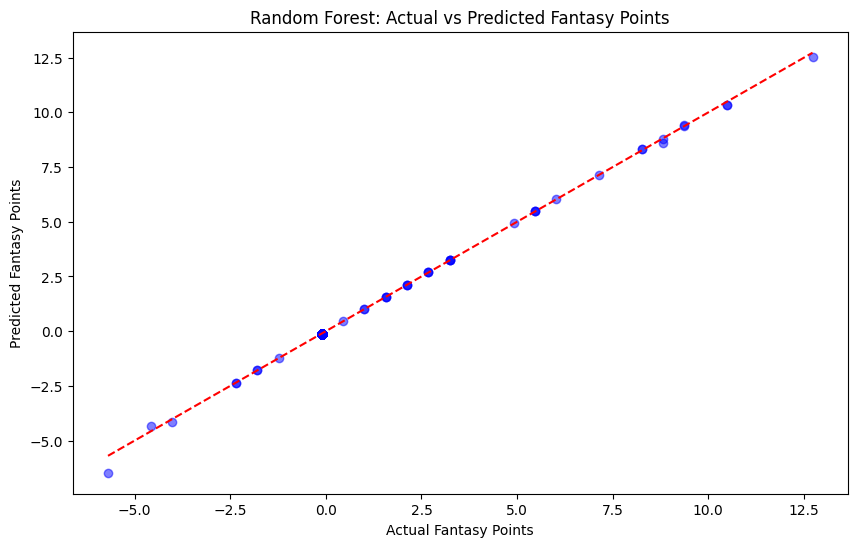

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions using the best Random Forest model (from GridSearchCV or RandomizedSearchCV)
y_pred_rf = best_rf_model.predict(X_test)

# Plotting Actual vs Predicted Fantasy Points
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Fantasy Points')
plt.ylabel('Predicted Fantasy Points')
plt.title('Random Forest: Actual vs Predicted Fantasy Points')
plt.show()

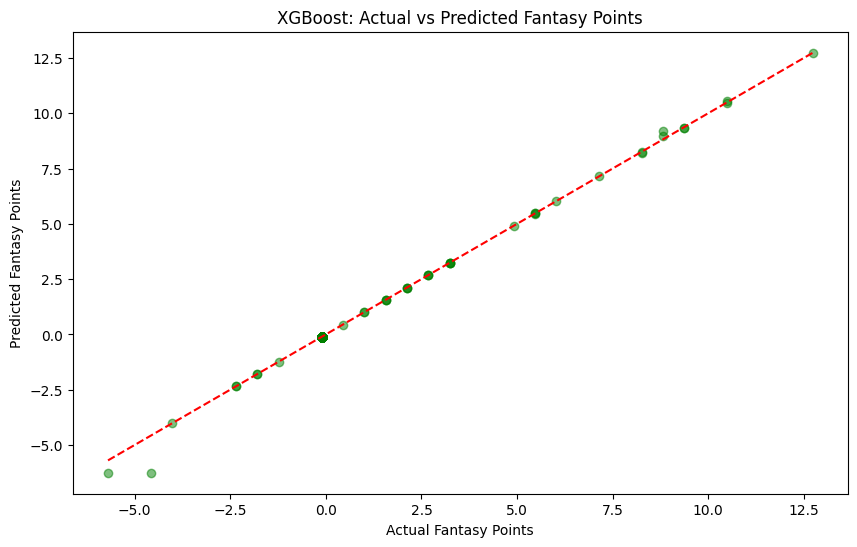

In [82]:
# Make predictions using the XGBoost model
y_pred_xg = xg_model.predict(X_test)

# Plotting Actual vs Predicted Fantasy Points for XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xg, color='green', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Fantasy Points')
plt.ylabel('Predicted Fantasy Points')
plt.title('XGBoost: Actual vs Predicted Fantasy Points')
plt.show()

In [88]:
import joblib
from sklearn.ensemble import RandomForestRegressor

# Assuming X_train and y_train are already defined
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Save the trained model to a .pkl file
joblib.dump(rf_model, 'best_rf_model.pkl')

['best_rf_model.pkl']

In [90]:
import joblib

# Load the trained model
rf_model = joblib.load('best_rf_model.pkl')

In [91]:
import streamlit as st
import joblib

# Load the trained model
model = joblib.load('best_rf_model.pkl')

# Streamlit user interface
st.title('Fantasy Points Prediction')

# User inputs
player_stats = st.text_input("Enter player stats: ")

# Make prediction when button is clicked
if st.button('Predict Fantasy Points'):
    input_data = [float(x) for x in player_stats.split(',')]
    prediction = model.predict([input_data])
    st.write(f"Predicted Fantasy Points: {prediction[0]}")

2025-01-18 00:29:19.831 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-18 00:29:19.832 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-18 00:29:19.833 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-18 00:29:19.833 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-18 00:29:19.834 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-18 00:29:19.835 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-18 00:29:19.836 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-18 00:29:19.836 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [93]:
# src/app.py
import streamlit as st
import joblib
import numpy as np

# Load your pre-trained model from the same directory as app.py
model = joblib.load('best_rf_model.pkl')  # Adjust this to load the model from the current directory

# Streamlit user interface
st.title('Fantasy Points Prediction')

# Input fields for prediction (assuming 5 features for simplicity)
age = st.number_input('Age', min_value=18, max_value=40)
exp = st.number_input('Experience', min_value=1, max_value=20)
g = st.number_input('Games Played', min_value=0, max_value=16)
cmp = st.number_input('Completions', min_value=0, max_value=50)
att = st.number_input('Attempts', min_value=0, max_value=50)

# Collect inputs into a numpy array
input_features = np.array([age, exp, g, cmp, att]).reshape(1, -1)

# Make prediction
if st.button('Predict'):
    prediction = model.predict(input_features)
    st.write(f'Predicted Fantasy Points: {prediction[0]}')

2025-01-18 00:32:19.881 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-18 00:32:19.883 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-18 00:32:19.885 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-18 00:32:19.886 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-18 00:32:19.887 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-18 00:32:19.888 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-18 00:32:19.888 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-18 00:32:19.889 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar